In [1]:
# Specify location to FlavorPy files
directory_to_git_folder = "/home/alex/GitRepos/FlavorPy/flavorpy"
import os
os.chdir(os.path.expanduser(directory_to_git_folder))

import modelfitting as mf
import numpy as np
import pandas as pd

# Detailed example

Let us now take a look at a more involved example that better showcases more advanced features of the modelfitting package. More specifically we consider the Model 1 described in section 3.1.2 of "Are neutrino masses modular forms?" by F. Feruglio (https://arxiv.org/pdf/1706.08749). This is a model of modular flavor symmetries, where modular forms are present in the neutrino mass matrix.

We begin by importing the necessary packages:

In [2]:
## Import the modelfitting module of FlavorPy
#import flavorpy.modelfitting as mf
#
## We will also need numpy and pandas
#import numpy as np
#import pandas as pd

## Mass matrices

Then we define the mass matrices. There is a subtlety: The modelfitting package considers a mass matrix $M$ for $\Phi_\mathrm{left} ~M~ \Phi_{\mathrm{right}}$. However the convention used in the paper is $E^c ~M_\mathrm{e}~L$, where $E^c$ is right-handed and $L$ is left-handed, meaning that we need to transpose the mass matrix compared to the paper! For this specific case the mass matrices are symmetric anyway. It is highly recommended to only use dimensionless parameters and then have one dimensionfull parameter, i.e. an overall scale, in front of the mass matrix. For the neutrino mass matrix, please name this parameter 'n_scale'. For the charged lepton mass matrix, simply ignore it, because we will only fit charged lepton mass ratios.

In [3]:
# Charged lepton mass matrix
def Me(params):
    return np.transpose(np.array([[params['alpha'], 0, 0],
                                  [0, params['beta'], 0],
                                  [0, 0, params['gamma']]]))

# Modular forms
def Y1(tau):
    q=np.exp(2j*np.pi*tau/3)
    return 1 + 12*np.power(q, 1*3) + 36*np.power(q, 2*3) + 12*np.power(q, 3*3)
def Y2(tau):
    q=np.exp(2j*np.pi*tau/3)
    return -6*q*(1 + 7*np.power(q,1*3) + 8*np.power(q, 2*3))
def Y3(tau):
    q=np.exp(2j*np.pi*tau/3)
    return -18*np.power(q, 2)*(1 + 2*np.power(q, 1*3) + 5*np.power(q, 2*3))

# Neutrino mass matrix
def Mn(params):
    tau = params['Retau']+1j*params['Imtau']
    return params['n_scale']*np.transpose(np.array([[2*Y1(tau), -1*Y3(tau), -1*Y2(tau)],
                                                    [-1*Y3(tau), 2*Y2(tau), -1*Y1(tau)],
                                                    [-1*Y2(tau), -1*Y1(tau), 2*Y3(tau)]], dtype=complex))

## Parameter space

Next we construct the parameter space. We therefore write our own sampling functions, that when called yield a random point. Note that especailly for fitting complicated models the sampling heavily impacts the number of random points (and therefore also the time) needed to find a good fit. A logarithmic sampling or a mixture of logarithmic and linear sampling is often a good idea. The ‘lin_sampling(low, high)’ defined here draws a random number between ‘low’ and ‘high’ with a uniform distribution. The ‘const_sampling(value)’ always yields ‘value’ when called. For our specific model, we can already know what the values of alpha, beta and gamma will be, since they are directly correlated to the charged lepton masses. We will therefore use const_sampling to set them by hand to a fixed value and prevent the fitting algorithm from varying this value by setting ‘vary=False’. For the modulus tau, we will choose the ‘lin_sampling’ and restrict the boundaries of the parameter space by ‘min’ and ‘max’.

In [4]:
# Sampling functions
def lin_sampling(low=0, high=1):
    def fct():
        return np.random.uniform(low=low, high=high)
    return fct
def const_sampling(value=0):
    def fct():
        return value
    return fct

# Constructing the parameter space
ParamSpace = mf.ParameterSpace()
ParamSpace.add_dim(name='Retau', sample_fct=lin_sampling(low=-0.5, high=0.5), min=-0.5, max=0.5)
ParamSpace.add_dim(name='Imtau', sample_fct=lin_sampling(low=0.866, high=3), min=0.866, max=4)
ParamSpace.add_dim(name='n_scale', sample_fct=const_sampling(1.), vary=False)
ParamSpace.add_dim(name='alpha', sample_fct=const_sampling(0.0048*0.0565), vary=False)
ParamSpace.add_dim(name='beta', sample_fct=const_sampling(0.0565), vary=False)
ParamSpace.add_dim(name='gamma', sample_fct=const_sampling(1.), vary=False)

## Experimental data

We already know from the paper that this model gives better fits with an invered neutrino mass ordering. We therefore choose the NuFit v5.2 experimental data for inverted ordering including the SK data. The onedimensional chisqure projections of the NuFit v5.2 data are already implemented in the modelfitting package and can be simply loaded by

In [5]:
mf.NuFit53_IO

NuFit v5.3 IO with SK chisquare profiles

If you wanted to compare your model to your own experimental data, you can create an experimental dataset by

In [6]:
my_table = pd.DataFrame(np.array([
    [0.0048, 0.0565, 0.303, 0.02223, 0.569, 0.0741/-2.486, 1.54, 7.41e-05, -2.486e-03],
    [0.0046, 0.0520, 0.292, 0.02165, 0.548, 0.0721/-2.511, 1.38, 7.21e-05, -2.458e-03],
    [0.0050, 0.0610, 0.315, 0.02281, 0.585, 0.0762/-2.458, 1.67, 7.62e-05, -2.511e-03]]),
                             columns=["me/mu", "mu/mt", "s12^2", "s13^2", "s23^2", "r", "d/pi", "m21^2", "m3l^2"],
                             index=['best', '1sig_min', '1sig_max'])
My_ExpData = mf.ExperimentalData(name='my name', data_table=my_table)

The total resudiual is then $\chi^2 = \sum_x \chi^2_x$, where $x$ represents the observables, e.g. ‘me/mu’. The individual contributions are determined by $\chi^2_x = \big(\dfrac{x_\mathrm{model} - x_\mathrm{best}}{1/2\,(x_{1\mathrm{sig}\_\mathrm{max}} - x_\mathrm{1sig\_min}) }\big)^2$, where $x_\mathrm{model}$ is the value of the model and $x_\mathrm{best}$, $x_{1\mathrm{sig\_max}}$, and $x_{1\mathrm{sig\_min}}$ are the experimental values


Alternatively, if you have a non-gaussian error distribution for lets say me/mu and you want $\chi^2$ to be calculated using a specific $\chi^2$-profile, then you can define your experimental data set as

In [7]:
def memu_profile(memu):  # This is just an example profile
    return 1e11*(memu - 0.003) * (memu - 0.007) * (memu - 0.008) * (memu - 0.001) + 3.0978

My_ExpData_2 = mf.ExperimentalData(name='my name2', 
                                   data_table=my_table[[key for key in my_table.columns if key not in ['me/mu']]],
                                   data={'me/mu':memu_profile})

## Constructing the model

In the modelfitting module, everything is packed into a class called FlavorModel. The FlavorModel object contains the mass matrices, the parameterspace, the experimental data, the neutrino mass ordering, and even the results of fits can be stored in this object. Note that the neutrino ordering is not (yet) automatically determined by the modelfitting package, nor is it checked whether the results of a given random point indeed follow that ordering. 
A FlavorModel instance can be a model of leptons, of quarks or of both. It depends on which mass matrices you specify when initializing the FlavorModel.

As the model of this example is a lepton model, we will only specify the mass_matrix_e and mass_matric_n. Since the paper does not compare the CP violating phase ‘d/pi’ to the experimental data, we will do the same here and only fit the three mixing angles as well as the squared neutrino mass differences. It is also not necessary to fit the charged lepton masses, since we already fixed them to their correct value.

In [8]:
Model1 = mf.FlavorModel(name='Feruglios model 1', 
                       comments='''This was the first modular flavor symmetry model.
                                Unfortunately it is now way outside the experimentally viable region.''',
                       mass_matrix_e=Me,
                       mass_matrix_n=Mn,
                       parameterspace=ParamSpace,
                       ordering='IO',
                       experimental_data=mf.NuFit53_IO,
                       fitted_observables=['s12^2', 's13^2', 's23^2', 'm21^2', 'm3l^2'])

You can now test if the model works, by calculating a random sample point

In [9]:
random_point = Model1.parameterspace.random_pt()
Model1.get_obs(random_point)

{'me/mu': 0.0048,
 'mu/mt': 0.0565,
 's12^2': 0.999889815537418,
 's13^2': 2.8667406090866322e-05,
 's23^2': 0.4921266138553866,
 'd/pi': 0.23645762527543615,
 'r': -0.9795497247469228,
 'm21^2': 0.001254630307860425,
 'm3l^2': -0.0012808235010066205,
 'm1': 0.02087600341297992,
 'm2': 0.04111493434701282,
 'm3': 0.020238930934032902,
 'eta1': 0.2362765443592603,
 'eta2': 0.3204549337296819,
 'J': 1.9003468739495824e-05,
 'Jmax': 2.809533105931343e-05,
 'Sum(m_i)': 0.08222986869402565,
 'm_b': 0.04111616890318147,
 'm_bb': 0.04111066795658337,
 'nscale': 0.020555777634506344}

If you wanted to see, whether the model can also fit the experimental data for a normal ordered spectrum simply define

In [10]:
Model1_NO = Model1.copy()
Model1_NO.ordering = 'NO'
Model1_NO.experimental_data = mf.NuFit53_NO

and do the following fitting with Model1_NO.

In case we were interested in studying a model that simultaneously descibes leptons and quarks and where the two sectors have a common parameter, we would define

In [11]:
# We need to define the quark mass matrices
def Mu(params):
    return np.array([[params['Retau'], 0.1, 0], [0, 0, params['Imtau']], [0, 1, 0.2]])

def Md(params):
    tau = params['Retau'] + 1j * params['Imtau']
    return np.array([[Y1(tau), 0, 0],
                     [0, Y2(tau), 0],
                     [0, 0, Y3(tau)]], dtype=complex)

# Also we would need to specify the quark experimental data. For example the data used in arXiv:2103.16311
Qexpdata_Standard = pd.DataFrame(np.array([
    [1.9286e-03, 2.8213e-03, 5.0523e-02, 1.8241e-02, 13.0268, 0.199962, 2.30043, 69.2133],
    [1.6278e-03, 2.7616e-03, 4.7428e-02, 1.7739e-02, 13.0059, 0.196238, 2.28210, 67.6560],
    [2.2295e-03, 2.8811e-03, 5.3619e-02, 1.8744e-02, 13.0477, 0.203686, 2.31877, 70.7706]]), 
                                 columns=["mu/mc","mc/mt","md/ms","ms/mb","t12","t13","t23","dq"], 
                                 index=['best', '1sig_min', '1sig_max'])
# and combine Lepton and Quark experimental data
LeptonQuark_data_table = pd.concat([mf.NuFit53_IO_gauss.data_table, Qexpdata_Standard], axis=1)
LeptonQuark_ExpData = mf.ExperimentalData(data_table=LeptonQuark_data_table)

# Then we can initialize the Lepton-Quark-Model
MyLeptonQuarkModel = mf.FlavorModel(mass_matrix_e=Me, mass_matrix_n=Mn,
                                    mass_matrix_u=Mu, mass_matrix_d=Md,
                                    parameterspace=ParamSpace,
                                    experimental_data=LeptonQuark_ExpData,
                                    ordering='IO',
                                    ckm_parameterization='standard')

## Fitting

We can now fit our model to match experimental data as good as possible. This is done by simply calling 'make_fit(points=int)' on the LeptonModel. This yields a pandas.DataFrame object, which is very convenient in data handling. Automatically, it is sorted such that the lowest $\chi^2$ is on top.

The fit is based on the lmfit minimizer, cf. https://lmfit.github.io/lmfit-py/intro.html. When fitting a LeptonModel a certain number of random points according to the sample functions of the parameter space are drawn. Then several minimization algorithms (methods) implemented in lmfit are applied consecutively several times (nr_methods) onto every random point. Since minimization algorithms sometimes get lost and run very long, every applied algorithm is stopped after a certain amount of second (max_time). These and other arguments used for the fit, can be adjusted to the individual needs. However, in most cases the default values work very well and it is not necessary to adjust them. Here, we will do it for the purpose of demonstation.

In [12]:
pd.set_option('display.max_columns', None)  # This pandas setting allows us to see all columns

# Adjusting the default setup for fitting.  Usually this is 
fitting_kwargs = {'nr_methods':2,
                  'methods':['least_squares', 'least_squares', 'nelder', 'powell', 'cobyla'],
                  'max_time':20}

# Running the fit
df = Model1.make_fit(points=5, **fitting_kwargs)
df

,chisq,chisq_dimless,Retau,Imtau,n_scale,alpha,beta,gamma,me/mu,mu/mt,s12^2,s13^2,s23^2,d/pi,r,m21^2,m3l^2,m1,m2,m3,eta1,eta2,J,Jmax,Sum(m_i),m_b,m_bb,nscale
0,1450.840160,1450.834863,-0.011631,0.994666,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.304975,0.044684,0.348874,1.454255,-0.029727,0.000074,-0.002489,0.049152,0.049899,0.000747,0.242450,1.027443,-0.043855,0.044312,0.099797,0.049273,0.038493,0.021938
1,1450.869308,1450.831289,0.011608,0.994678,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.304997,0.044684,0.348874,0.545733,-0.029669,0.000074,-0.002492,0.049177,0.049923,0.000746,1.757572,0.972569,0.043856,0.044313,0.099847,0.049296,0.038513,0.021950
2,1450.870137,1450.831319,0.011607,0.994678,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.305002,0.044684,0.348874,0.545732,-0.029668,0.000074,-0.002492,0.049178,0.049924,0.000746,1.757576,0.972573,0.043857,0.044313,0.099848,0.049296,0.038513,0.021950
3,1450.870886,1450.831218,0.011607,0.994678,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.305000,0.044684,0.348874,0.545732,-0.029666,0.000074,-0.002492,0.049178,0.049924,0.000746,1.757575,0.972571,0.043856,0.044313,0.099849,0.049297,0.038514,0.021950
4,1450.870897,1450.831219,0.011607,0.994678,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.305000,0.044684,0.348874,0.545732,-0.029666,0.000074,-0.002492,0.049178,0.049924,0.000746,1.757575,0.972571,0.043856,0.044313,0.099849,0.049297,0.038514,0.021950
5,1450.873011,1450.831209,-0.011606,0.994679,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.305000,0.044684,0.348874,1.454268,-0.029664,0.000074,-0.002492,0.049180,0.049926,0.000746,0.242425,1.027429,-0.043856,0.044313,0.099851,0.049298,0.038515,0.021951
6,1450.873011,1450.831209,-0.011606,0.994679,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.305000,0.044684,0.348874,1.454268,-0.029664,0.000074,-0.002492,0.049180,0.049926,0.000746,0.242425,1.027429,-0.043856,0.044313,0.099851,0.049298,0.038515,0.021951
7,1450.875212,1450.831233,-0.011605,0.994679,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.305000,0.044684,0.348874,1.454269,-0.029661,0.000074,-0.002492,0.049181,0.049927,0.000746,0.242425,1.027428,-0.043856,0.044313,0.099854,0.049299,0.038516,0.021951
8,1450.875235,1450.831215,-0.011605,0.994679,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.305000,0.044684,0.348874,1.454268,-0.029661,0.000074,-0.002492,0.049181,0.049927,0.000746,0.242425,1.027429,-0.043856,0.044313,0.099854,0.049299,0.038516,0.021951
9,1450.957056,1450.886723,-0.011609,0.994722,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.306397,0.044684,0.348874,1.454640,-0.029628,0.000074,-0.002493,0.049195,0.049940,0.000745,0.241250,1.026557,-0.043920,0.044370,0.099881,0.049311,0.038526,0.021959


We can also store this result for later purpose in the LeptonModel object

In [13]:
Model1.fit_results.append(df)  # call it with Model1.fit_results[0]

The fitting of this model is rather easy and does not require a lot of recources. However, if one was to fit a more involved model with more parameters, it can be necessary to run the fit on an external machine, e.g. a server, and then transfer the result back to your local machine. To keep the transfer-file as small as possible it is advisable to only do the dimensionless fit on the external machine, since this is the computation heavy part. The fitting of the neutrino mass scale and adding of all lepton observables can then be done on the local machine. The workflow would be as follows

In [13]:
# On the external machine, define the model and then run
df = Model1.dimless_fit(points=10)

# Then export 'df' to a file, e.g. a csv with 'df.to_csv("/path_to_file/results.csv", index=False)'
# Transfer this file 'results.csv' to your local machine
# On your local machine, import the file as 'df' with, e.g. 'df = pd.read_csv("/path_to_file/results.csv")'

# This df only contains the values of the parameters and chisquare. To add the lepton observables call
df = Model1.complete_fit(df)

# And store it in the model
Model1.fit_results.append(df)

Analogously we could fit our Lepton-Quark-Model with

In [14]:
tmp = MyLeptonQuarkModel.make_fit(points=10)
tmp.head(5)

,chisq,chisq_dimless,Retau,Imtau,n_scale,alpha,beta,gamma,me/mu,mu/mt,s12^2,s13^2,s23^2,d/pi,r,m21^2,m3l^2,m1,m2,m3,eta1,eta2,J,Jmax,Sum(m_i),m_b,m_bb,nscale,mu/mc,mc/mt,md/ms,ms/mb,t12,t13,t23,dq
0,29819.562345,27889.667489,-0.5,1.027139,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.632693,0.033717,0.132304,2.0,-0.791345,0.001021,-0.00129,0.023138,0.039452,0.016314,1.0,1.0,-8.431851e-17,0.028981,0.078904,0.043305,0.032882,0.016195,0.538355,0.822271,0.351797,0.703595,14.256250,82.076160,59.363982,180.0
1,29819.563629,27889.667484,-0.5,1.027168,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.632725,0.033713,0.132319,2.0,-0.791323,0.001021,-0.00129,0.023138,0.039452,0.016313,1.0,1.0,-2.347008e-13,0.028980,0.078904,0.043305,0.032882,0.016196,0.538348,0.822271,0.351775,0.703550,14.255616,82.076192,59.367621,180.0
2,29819.563667,27889.667484,-0.5,1.027169,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.632726,0.033713,0.132320,2.0,-0.791322,0.001021,-0.00129,0.023138,0.039452,0.016313,1.0,1.0,-2.503838e-15,0.028980,0.078904,0.043305,0.032882,0.016196,0.538347,0.822271,0.351774,0.703549,14.255597,82.076193,59.367727,180.0
3,29819.563687,27889.667484,-0.5,1.027170,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.632726,0.033713,0.132320,2.0,-0.791322,0.001021,-0.00129,0.023138,0.039452,0.016313,1.0,1.0,-1.357960e-16,0.028980,0.078904,0.043305,0.032882,0.016196,0.538347,0.822271,0.351774,0.703548,14.255587,82.076193,59.367784,180.0
4,29819.563694,27889.667484,-0.5,1.027170,1.0,0.000271,0.0565,1.0,0.0048,0.0565,0.632726,0.033713,0.132320,2.0,-0.791321,0.001021,-0.00129,0.023138,0.039452,0.016313,1.0,1.0,-1.357960e-16,0.028980,0.078904,0.043305,0.032882,0.016196,0.538347,0.822271,0.351774,0.703548,14.255584,82.076193,59.367804,180.0


## Analysing results

You can now analyse the pandas.DataFrame that contains the fit results conveniently with all the methods that pandas provides. For this example, let us just look at the $\chi^2$-decomposition of the best fit point

In [15]:
Model1.print_chisq(df.loc[0])

's12^2': 0.3049753248207408,   chisq: 0.0008610874231279788
's13^2': 0.04468384581156096,   chisq: 1371.4143830828527
's23^2': 0.3488737891713785,   chisq: 79.41605107231653
'm21^2': 7.400113796594195e-05,   chisq: 0.0020254325309340816
'm3l^2': -0.0024893256217561536,   chisq: 0.006839537831949735
Total chi-square: 1450.8401602129552


As also discussed in the paper, the mixing angle $\theta_{13}$ seems not to be in agreement with the experimental data. 

## Exploring a minimum with Markov Chain Monte Carlo (MCMC)

Using the emcee marcov chain monte carlo sampler one can conveniently explore the neighborhood and hence the confidence level contours of a specific minimum. FlavorPy uses the emcee (https://emcee.readthedocs.io/en/stable/) MCMC sampler. To sample with a given amount x of mcmc_steps around one or multiple minima of a FlavorModel, simply call FlavorModel.mcmc_fit(df, mcmc_steps=x). You can also pass down keyword arguments to the underlying lmfit.Minimizer.emcee and emcee.EnsembleSampler.run_mcmc, see https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.Minimizer.emcee and https://emcee.readthedocs.io/en/stable/user/sampler/#emcee.EnsembleSampler.run_mcmc there are several interesting options like adjusting the number of ranodm walkers of parallelizing the job using several workers. Calling the function yields the flatchain containing all sampled points in parameter space. The observables and chisq can the easily be added with FlavorModel.complete_fit(df).

In [16]:
mcmc_kwargs = {'nwalkers':60, 'thin':2, 'workers':5}
df_mcmc = Model1.mcmc_fit(df.loc[[0]], mcmc_steps=2000, **mcmc_kwargs)
df_mcmc = Model1.complete_fit(df_mcmc)

0 : 


100%|██████████| 2000/2000 [01:03<00:00, 31.39it/s]


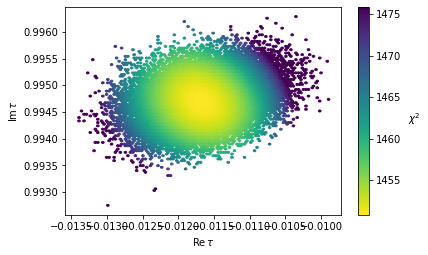

In [17]:
mf.plot(df_mcmc, x='Retau', y='Imtau', cmap='viridis_r', vmax=np.min(df_mcmc['chisq'])+25);

This method is especially usefull if you want to sample around multiple minima.
Alternatively with FlavorPy you can directly define a lmfit.Minimizer object, on which you can call .emcee(). This enables you to use a wide range of analysis tools of lmfit (https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) and emcee (https://emcee.readthedocs.io/en/stable/tutorials/quickstart/). However, you can only fit one minimum at a time. And you need to input the minimum in form of a lmfit.Parameters object.

In [18]:
params = ParamSpace.random_pt()  # This is not a random point, but we will set it to the best fit point df.loc[0] in the next lines
for param in params:
    params[param].value = df.loc[0][param]

LmfitMinimizer = mf.LmfitMinimizer(model=Model1, params=params)

This has the nice feature, that you can sample a couple of points and if they were not sufficiently many, you can continue running the same, already trained, sampler with 'reuse_sampler'.

In [19]:
res = LmfitMinimizer.emcee(steps=1000)

100%|██████████| 1000/1000 [00:45<00:00, 21.78it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.81724905 25.39524904]


In [20]:
len(res.flatchain)

100000

In [21]:
res = LmfitMinimizer.emcee(steps=1000, reuse_sampler=True)

100%|██████████| 1000/1000 [00:45<00:00, 21.96it/s]


In [22]:
len(res.flatchain)

200000

Also you can print all sorts of information about the fit results. For more information see https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult.

In [23]:
res